In [1]:
#计算有多少highinfo和lowinfo，将feature&edge中不属于label的node找出来一些作为全0的embedding

In [2]:
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import pandas as pd
from torch_geometric.data import Data
from torch_geometric.utils import negative_sampling
edges_df = pd.read_csv('GNN/protein_interactions.csv')

col_name = ['protein']
for i in range(1,769):
  col_name.append('feature'+str(i))
features_df = pd.read_csv('GNN/gene_embedding_GeneLLM_2.csv', header=None, names=col_name)

print(features_df)
labels_df = pd.read_csv('GNN/solubility.csv')

/tmp/ipykernel_3194499/1133472201.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/tmp/ipykernel_3194499/1133472201.py:7: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  edges_df = pd.read_csv('GNN/protein_interactions.csv')


      protein  feature1  feature2  feature3  feature4  feature5  feature6  \
0         FES  0.339602 -0.030744 -0.901381  0.100888  0.886443  0.383596   
1      HADHA  -0.131799 -0.025745 -0.677301 -0.053545  0.971046  0.180315   
2      SLC7A7  0.385693 -0.070692 -0.847796 -0.022054  0.959772  0.085487   
3        LCK   0.650428  0.014479 -0.866163  0.053508  0.951529  0.269402   
4       HSPA2  0.322262  0.017484 -0.849302  0.046401  0.920429  0.463832   
...       ...       ...       ...       ...       ...       ...       ...   
14445   BPY2C -0.840158 -0.042814 -0.853394 -0.049438  0.943925  0.104337   
14446    CLPS -0.270716 -0.036871 -0.915350 -0.013635  0.972046  0.016017   
14447    DNER  0.228932 -0.033579 -0.907262  0.010446  0.961684  0.524211   
14448    SOX7  0.140491  0.033339 -0.806014 -0.072016  0.938781  0.339959   
14449  CXCL14 -0.570266 -0.011502 -0.741149 -0.096209  0.967244  0.426519   

       feature7  feature8  feature9  ...  feature759  feature760  feature76

In [3]:
print(labels_df)
edges_df['combined_score'][7] = 594
edges_df_cleaned = edges_df.dropna()
print(edges_df_cleaned)
edges_df_cleaned = edges_df.dropna()
print(edges_df_cleaned)

     Gene name Solubility  Label  Word_Count Count_Category
0        ERAP2   Membrane      0         117     High Count
1     ADAMTSL5    Soluble      1          28      Low Count
2      TBC1D30   Membrane      0          55     High Count
3       KCNK18   Membrane      0         184     High Count
4         NDNF    Soluble      1         129     High Count
...        ...        ...    ...         ...            ...
1374   TRABD2B   Membrane      0          96     High Count
1375      RPS9    Soluble      1         205     High Count
1376  SLC22A16   Membrane      0          93     High Count
1377      FBN3    Soluble      1          90     High Count
1378      BDH2    Soluble      1         102     High Count

[1379 rows x 5 columns]


/tmp/ipykernel_3194499/3707133632.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  edges_df['combined_score'][7] = 594


         protein1  protein2 combined_score
0            ARF5   RALGPS2            173
1            ARF5     FHDC1            154
2            ARF5  ATP6V1E1            151
3            ARF5     CYTH2            471
4            ARF5      PSD3            201
...           ...       ...            ...
13715123     LDB1    SAMD14            260
13715124     LDB1     KDM6B            161
13715125     LDB1      WWP2            229
13715126     LDB1    VPS33B            152
13715127     LDB1     NDST2            440

[13067419 rows x 3 columns]
         protein1  protein2 combined_score
0            ARF5   RALGPS2            173
1            ARF5     FHDC1            154
2            ARF5  ATP6V1E1            151
3            ARF5     CYTH2            471
4            ARF5      PSD3            201
...           ...       ...            ...
13715123     LDB1    SAMD14            260
13715124     LDB1     KDM6B            161
13715125     LDB1      WWP2            229
13715126     LDB1    VPS3

In [4]:
node_id_f = [node_id for node_id in features_df['protein']]
node_id_e1 = [node_id for node_id in edges_df_cleaned['protein1']]
node_id_e2 = [node_id for node_id in edges_df_cleaned['protein2']]
node_id_e = list(set(node_id_e1 + node_id_e2))
print(len(node_id_f))
print(len(node_id_e))

14450
18838


In [5]:
labels_df.rename(columns={'Gene name': 'protein'}, inplace=True)
labels_df

,protein,Solubility,Label,Word_Count,Count_Category
0,ERAP2,Membrane,0,117,High Count
1,ADAMTSL5,Soluble,1,28,Low Count
2,TBC1D30,Membrane,0,55,High Count
3,KCNK18,Membrane,0,184,High Count
4,NDNF,Soluble,1,129,High Count
...,...,...,...,...,...
1374,TRABD2B,Membrane,0,96,High Count
1375,RPS9,Soluble,1,205,High Count
1376,SLC22A16,Membrane,0,93,High Count
1377,FBN3,Soluble,1,90,High Count


In [6]:
nodes_in_edges = set(edges_df['protein1']).union(set(edges_df['protein2']))
nodes_in_features = set(features_df['protein'])
missing_nodes = list(nodes_in_edges - nodes_in_features)
average_features = features_df.iloc[:, 1:].mean()

# 为缺失的节点创建平均特征
missing_features =pd.DataFrame([average_features.values] * len(missing_nodes), columns=average_features.index)
missing_features['protein'] = missing_nodes
missing_features = missing_features[features_df.columns]

# 合并原始特征和缺失节点的特征
new_features_df = pd.concat([features_df, missing_features], ignore_index=True)
new_features_df

,protein,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature759,feature760,feature761,feature762,feature763,feature764,feature765,feature766,feature767,feature768
0,FES,0.339602,-0.030744,-0.901381,0.100888,0.886443,0.383596,-0.192082,-0.032063,-0.154869,...,-0.549204,-0.856123,0.714672,-0.046649,-0.894424,-0.001815,0.739485,0.015581,-0.023863,-0.022002
1,HADHA,-0.131799,-0.025745,-0.677301,-0.053545,0.971046,0.180315,-0.028189,-0.077389,-0.095152,...,0.927885,-0.817812,0.809631,-0.005827,-0.848839,0.024516,0.526404,-0.039926,-0.102787,-0.026980
2,SLC7A7,0.385693,-0.070692,-0.847796,-0.022054,0.959772,0.085487,0.076455,-0.003006,-0.032268,...,0.941094,-0.912443,0.789828,0.046979,-0.715636,0.085842,0.150494,0.025392,-0.066035,-0.028283
3,LCK,0.650428,0.014479,-0.866163,0.053508,0.951529,0.269402,-0.214788,0.045179,-0.506429,...,-0.576739,-0.969558,0.916549,-0.080332,-0.927649,-0.047398,0.741663,-0.000096,-0.096318,-0.056501
4,HSPA2,0.322262,0.017484,-0.849302,0.046401,0.920429,0.463832,-0.050414,-0.033398,0.387791,...,0.387301,-0.860696,0.678607,-0.060695,-0.945793,0.040472,0.831079,-0.001711,-0.079842,-0.011189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19196,OR5D3P,0.166824,-0.022353,-0.818924,-0.015590,0.938668,0.350558,-0.064741,-0.024466,0.048526,...,0.638018,-0.851449,0.644471,-0.036707,-0.842413,0.005465,0.456407,-0.028600,-0.076502,-0.027952
19197,OR10G4,0.166824,-0.022353,-0.818924,-0.015590,0.938668,0.350558,-0.064741,-0.024466,0.048526,...,0.638018,-0.851449,0.644471,-0.036707,-0.842413,0.005465,0.456407,-0.028600,-0.076502,-0.027952
19198,OR5P2,0.166824,-0.022353,-0.818924,-0.015590,0.938668,0.350558,-0.064741,-0.024466,0.048526,...,0.638018,-0.851449,0.644471,-0.036707,-0.842413,0.005465,0.456407,-0.028600,-0.076502,-0.027952
19199,SLC6A14,0.166824,-0.022353,-0.818924,-0.015590,0.938668,0.350558,-0.064741,-0.024466,0.048526,...,0.638018,-0.851449,0.644471,-0.036707,-0.842413,0.005465,0.456407,-0.028600,-0.076502,-0.027952


In [7]:
# 从边数据集获取节点
nodes_in_edges = set(edges_df_cleaned['protein1']).union(set(edges_df_cleaned['protein2']))

# 从特征数据集获取节点
nodes_in_features = set(features_df['protein'])

# 找出共同的节点
common_nodes = nodes_in_edges.intersection(nodes_in_features)

# 过滤边数据集，保留只包含共同节点的边
filtered_edges_df = edges_df_cleaned[edges_df_cleaned['protein1'].isin(common_nodes) & edges_df_cleaned['protein2'].isin(common_nodes)].reset_index(drop=True)

# 过滤特征数据集，保留共同节点的特征
filtered_features_df = features_df[features_df['protein'].isin(common_nodes)].reset_index(drop=True)

In [8]:
filtered_edges_df

,protein1,protein2,combined_score
0,ARF5,RALGPS2,173
1,ARF5,FHDC1,154
2,ARF5,ATP6V1E1,151
3,ARF5,CYTH2,471
4,ARF5,PSD3,201
...,...,...,...
9503498,LDB1,PGAP6,197
9503499,LDB1,KDM6B,161
9503500,LDB1,WWP2,229
9503501,LDB1,VPS33B,152


In [9]:
filtered_features_df

,protein,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature759,feature760,feature761,feature762,feature763,feature764,feature765,feature766,feature767,feature768
0,FES,0.339602,-0.030744,-0.901381,0.100888,0.886443,0.383596,-0.192082,-0.032063,-0.154869,...,-0.549204,-0.856123,0.714672,-0.046649,-0.894424,-0.001815,0.739485,0.015581,-0.023863,-0.022002
1,SLC7A7,0.385693,-0.070692,-0.847796,-0.022054,0.959772,0.085487,0.076455,-0.003006,-0.032268,...,0.941094,-0.912443,0.789828,0.046979,-0.715636,0.085842,0.150494,0.025392,-0.066035,-0.028283
2,HSPA2,0.322262,0.017484,-0.849302,0.046401,0.920429,0.463832,-0.050414,-0.033398,0.387791,...,0.387301,-0.860696,0.678607,-0.060695,-0.945793,0.040472,0.831079,-0.001711,-0.079842,-0.011189
3,ZSCAN9,-0.132130,-0.048746,-0.844795,0.013757,0.963150,0.614866,-0.126746,-0.017795,-0.464897,...,0.987995,-0.719372,0.739748,0.122923,-0.982124,-0.104269,0.696067,-0.015833,-0.163702,0.037182
4,SNX10,0.418061,-0.084858,-0.917636,-0.053882,0.942593,0.590945,-0.142904,-0.005636,-0.006018,...,0.768108,-0.841070,0.306929,-0.030281,-0.918397,0.043871,0.892007,0.010785,-0.074765,-0.066948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14083,IQCJ-SCHIP1,0.092851,-0.004035,-0.841137,-0.094960,0.741134,-0.082558,-0.051283,-0.074935,0.052519,...,0.836989,-0.510768,0.568964,-0.120246,-0.577445,0.002407,-0.329807,-0.055330,-0.065028,0.007841
14084,CLPS,-0.270716,-0.036871,-0.915350,-0.013635,0.972046,0.016017,-0.018190,-0.008408,0.548612,...,0.946926,-0.739839,0.755471,0.006047,-0.488539,0.009771,-0.261908,-0.048952,-0.062768,0.019626
14085,DNER,0.228932,-0.033579,-0.907262,0.010446,0.961684,0.524211,-0.214318,0.039835,0.433141,...,0.806205,-0.857853,0.223238,-0.078767,-0.973104,0.026339,0.918282,-0.041604,-0.039557,-0.014415
14086,SOX7,0.140491,0.033339,-0.806014,-0.072016,0.938781,0.339959,-0.045201,-0.004075,-0.169557,...,0.756285,-0.889968,0.837899,-0.030372,-0.969834,-0.054169,0.099373,0.018777,-0.166461,-0.062177


In [10]:
# 将第二列中的两种字符映射为0和1
unique_values = labels_df['Count_Category'].unique()
print(unique_values)
mapping = {unique_values[0]: 0, unique_values[1]: 1}

labels_df['Count_Category'] = labels_df['Count_Category'].map(mapping)
# 显示更新后的DataFrame
print(labels_df)

['High Count' 'Low Count']
       protein Solubility  Label  Word_Count  Count_Category
0        ERAP2   Membrane      0         117               0
1     ADAMTSL5    Soluble      1          28               1
2      TBC1D30   Membrane      0          55               0
3       KCNK18   Membrane      0         184               0
4         NDNF    Soluble      1         129               0
...        ...        ...    ...         ...             ...
1374   TRABD2B   Membrane      0          96               0
1375      RPS9    Soluble      1         205               0
1376  SLC22A16   Membrane      0          93               0
1377      FBN3    Soluble      1          90               0
1378      BDH2    Soluble      1         102               0

[1379 rows x 5 columns]


In [11]:
node_id_to_index = {node_id: i for i, node_id in enumerate(filtered_features_df['protein'])}
# 确保edge_index是按照这个新的索引顺序排列的
source_indices = [node_id_to_index[node_id] for node_id in filtered_edges_df['protein1']]
target_indices = [node_id_to_index[node_id] for node_id in filtered_edges_df['protein2']]
edge_index = torch.tensor([source_indices, target_indices], dtype=torch.long)
filtered_edges_df['combined_score'] = pd.to_numeric(filtered_edges_df['combined_score'], errors='coerce', downcast='float')
edge_weight = torch.tensor(filtered_edges_df['combined_score'].values, dtype=torch.float)

# 重排特征矩阵以匹配edge_index的顺序
features = filtered_features_df.iloc[:, 1:].values
#features = features[[node_id_to_index[node_id] for node_id in filtered_features_df['protein']], :]

# 转换为PyTorch张量
features_tensor = torch.tensor(features, dtype=torch.float)

In [12]:
print(len(labels_df))
nodes_in_labels = set(labels_df['protein'])
nodes_in_filter_features = set(filtered_features_df['protein'])
common_nodes_labels = nodes_in_labels.intersection(nodes_in_filter_features)

# 过滤
filtered_labels_df = labels_df[labels_df['protein'].isin(common_nodes_labels)].reset_index(drop=True)
print(len(filtered_labels_df))
print(len(features_tensor))

1379
1355
14088


In [13]:
label_indices = [node_id_to_index[node_id] for node_id in filtered_labels_df['protein']]
print(label_indices)
num_nodes = 14088
labels = torch.full((num_nodes,), -1, dtype=torch.long)
for i, index in enumerate(filtered_labels_df['Label']):
    labels[label_indices[i]] = index

labels_tensor = torch.tensor(labels, dtype=torch.long)

[61, 75, 87, 88, 94, 109, 122, 135, 139, 140, 148, 157, 160, 192, 218, 225, 229, 231, 243, 246, 264, 269, 275, 282, 292, 305, 307, 319, 325, 354, 358, 360, 366, 367, 380, 383, 398, 422, 430, 449, 458, 459, 465, 473, 485, 492, 500, 532, 543, 559, 560, 561, 567, 568, 569, 570, 573, 588, 614, 625, 626, 636, 654, 707, 724, 732, 734, 743, 747, 751, 800, 817, 858, 859, 863, 878, 880, 901, 907, 920, 945, 959, 965, 981, 1002, 1009, 1015, 1024, 1025, 1026, 1028, 1035, 1036, 1039, 1040, 1066, 1069, 1076, 1077, 1080, 1084, 1091, 1096, 1097, 1103, 1117, 1130, 1133, 1143, 1154, 1155, 1156, 1174, 1193, 1194, 1200, 1213, 1218, 1219, 1229, 1230, 1232, 1264, 1268, 1279, 1285, 1299, 1314, 1322, 1328, 1329, 1334, 1343, 1348, 1377, 1378, 1382, 1386, 1395, 1396, 1419, 1420, 1425, 1434, 1439, 1442, 1443, 1470, 1476, 1489, 1497, 1508, 1524, 1542, 1555, 1558, 1563, 1565, 1567, 1585, 1586, 1593, 1622, 1629, 1658, 1668, 1681, 1684, 1685, 1706, 1723, 1742, 1754, 1770, 1779, 1780, 1790, 1794, 1795, 1798, 1800, 18

/tmp/ipykernel_3194499/4104203764.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_tensor = torch.tensor(labels, dtype=torch.long)


In [14]:
highinfo_indices = [
    node_id_to_index[node_id]
    for node_id, weight in zip(filtered_labels_df['protein'], filtered_labels_df['Count_Category'])
    if weight == 0
]
print(highinfo_indices)
lowinfo_indices = [
    node_id_to_index[node_id]
    for node_id, weight in zip(filtered_labels_df['protein'], filtered_labels_df['Count_Category'])
    if weight == 1
]
print(lowinfo_indices)


[61, 87, 88, 94, 109, 122, 135, 139, 148, 157, 218, 225, 229, 243, 264, 275, 282, 307, 319, 325, 354, 358, 360, 366, 367, 380, 383, 398, 422, 449, 458, 465, 473, 485, 492, 500, 532, 543, 560, 561, 567, 568, 569, 570, 573, 588, 614, 626, 636, 654, 707, 724, 734, 747, 800, 817, 858, 859, 863, 878, 880, 901, 907, 920, 945, 959, 965, 981, 1002, 1015, 1024, 1025, 1026, 1028, 1035, 1036, 1039, 1040, 1066, 1069, 1076, 1077, 1080, 1084, 1091, 1096, 1097, 1103, 1117, 1130, 1133, 1143, 1154, 1155, 1156, 1174, 1193, 1194, 1200, 1213, 1218, 1229, 1230, 1232, 1264, 1268, 1279, 1285, 1299, 1314, 1328, 1329, 1343, 1348, 1378, 1395, 1396, 1419, 1420, 1425, 1434, 1439, 1442, 1443, 1470, 1497, 1508, 1524, 1542, 1558, 1563, 1565, 1567, 1585, 1586, 1622, 1629, 1668, 1681, 1684, 1685, 1706, 1723, 1742, 1754, 1779, 1780, 1790, 1795, 1798, 1800, 1825, 1836, 1838, 1841, 1857, 1860, 1866, 1901, 1911, 1913, 1918, 1926, 1935, 1955, 1970, 1985, 1987, 2010, 2033, 2034, 2038, 2046, 2051, 2053, 2073, 2084, 2087, 209

In [15]:
print(len(highinfo_indices))
print(len(lowinfo_indices))

1184
171


In [16]:
high_info_genes = filtered_labels_df[filtered_labels_df['Count_Category'] == 0]['protein'].sample(frac=0.1)
mask_features_df = filtered_features_df.copy()
mask_labels_df = filtered_labels_df.copy()
for gene in high_info_genes:
    mask_features_df.loc[mask_features_df['protein'] == gene, 'feature1':'feature768'] = 0
    mask_labels_df.loc[mask_labels_df['protein'] == gene, 'Count_Category'] = 1
features = mask_features_df.iloc[:, 1:].values
features_tensor = torch.tensor(features, dtype=torch.float)

In [17]:
new_highinfo_indices = [
    node_id_to_index[node_id]
    for node_id, weight in zip(mask_labels_df['protein'], mask_labels_df['Count_Category'])
    if weight == 0
]
print(highinfo_indices)
new_lowinfo_indices = [
    node_id_to_index[node_id]
    for node_id, weight in zip(mask_labels_df['protein'], mask_labels_df['Count_Category'])
    if weight == 1
]
print(lowinfo_indices)

[61, 87, 88, 94, 109, 122, 135, 139, 148, 157, 218, 225, 229, 243, 264, 275, 282, 307, 319, 325, 354, 358, 360, 366, 367, 380, 383, 398, 422, 449, 458, 465, 473, 485, 492, 500, 532, 543, 560, 561, 567, 568, 569, 570, 573, 588, 614, 626, 636, 654, 707, 724, 734, 747, 800, 817, 858, 859, 863, 878, 880, 901, 907, 920, 945, 959, 965, 981, 1002, 1015, 1024, 1025, 1026, 1028, 1035, 1036, 1039, 1040, 1066, 1069, 1076, 1077, 1080, 1084, 1091, 1096, 1097, 1103, 1117, 1130, 1133, 1143, 1154, 1155, 1156, 1174, 1193, 1194, 1200, 1213, 1218, 1229, 1230, 1232, 1264, 1268, 1279, 1285, 1299, 1314, 1328, 1329, 1343, 1348, 1378, 1395, 1396, 1419, 1420, 1425, 1434, 1439, 1442, 1443, 1470, 1497, 1508, 1524, 1542, 1558, 1563, 1565, 1567, 1585, 1586, 1622, 1629, 1668, 1681, 1684, 1685, 1706, 1723, 1742, 1754, 1779, 1780, 1790, 1795, 1798, 1800, 1825, 1836, 1838, 1841, 1857, 1860, 1866, 1901, 1911, 1913, 1918, 1926, 1935, 1955, 1970, 1985, 1987, 2010, 2033, 2034, 2038, 2046, 2051, 2053, 2073, 2084, 2087, 209

In [18]:
print(len(new_highinfo_indices))
print(len(new_lowinfo_indices))

1066
289


In [19]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 128)
        self.conv2 = GCNConv(128, hidden_dim)
        self.fc1 = torch.nn.Linear(hidden_dim, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, num_classes)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x, edge_index, edge_weight):
        # 保存初始特征
        initial_features = x

        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)

        # 在这里将初始特征和 GCN 的输出拼接在一起
        #x = torch.cat([x, initial_features], dim=1)

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)  # 应用 Sigmoid 激活函数进行逻辑回归
        return x

def high_to_low(features, edge_index, edge_weight, labels, rates, label_indices,labels_tensor,node_id_to_index):
    accuracies = []
    accuracies_l = []
    accuracies_h = []
    for rate in rates:
        high_info_genes = labels[labels['Count_Category'] == 0]['protein'].sample(frac=rate)
        mask_features_df = features.copy()
        mask_labels_df = labels.copy()
        for gene in high_info_genes:
            mask_features_df.loc[mask_features_df['protein'] == gene, 'feature1':'feature768'] = 0
            mask_labels_df.loc[mask_labels_df['protein'] == gene, 'Count_Category'] = 1
        features_df = mask_features_df.copy()
        features_df = features_df.iloc[:, 1:].values
        features_tensor = torch.tensor(features_df, dtype=torch.float)
        
        new_highinfo_indices = [
            node_id_to_index[node_id]
            for node_id, weight in zip(mask_labels_df['protein'], mask_labels_df['Count_Category'])
            if weight == 0
        ]
        new_lowinfo_indices = [
            node_id_to_index[node_id]
            for node_id, weight in zip(mask_labels_df['protein'], mask_labels_df['Count_Category'])
            if weight == 1
        ]
        
        data = Data(x=features_tensor, edge_index=edge_index, y=labels_tensor, edge_attr=edge_weight)
        print(data.y)
        device = torch.device('cuda')
        data = data.to(device)
        
        model = GCN(num_features=features_df.shape[1], hidden_dim=64, num_classes=1).to(device)
        
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
        label_indices = torch.tensor(label_indices, dtype=torch.long)
        #print(label_indices)
        # 随机打乱有标签的节点索引
        #labeled_indices = label_indices[torch.randperm(label_indices.size(0))]
        #print(labeled_indices)
        labeled_indices = label_indices
        
        # 定义训练和测试集的大小
        num_labeled = labeled_indices.size(0)
        num_train = int(num_labeled * 0.8)
        num_test = num_labeled - num_train
        
        # 创建训练和测试掩码
        train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        
        train_mask[labeled_indices[:num_train]] = True
        test_mask[labeled_indices[num_train:num_train+num_test]] = True
        model.train()
        for epoch in range(3000):
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.edge_attr).squeeze()
            loss = criterion(out[train_mask], data.y[train_mask].float())
            loss.backward()
            optimizer.step()
            
            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')
        
        high_indices = torch.tensor(new_highinfo_indices, dtype=torch.long)
        high_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        high_mask[high_indices] = True
        test_high = high_mask & test_mask
        low_indices = torch.tensor(new_lowinfo_indices, dtype=torch.long)
        low_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        low_mask[low_indices] = True
        test_low = low_mask & test_mask
        print("The number of test highinfo: is {} and the number of test lowinfo {}.".format(len(high_indices), len(low_indices)))
        
        model.eval()
        with torch.no_grad():
            probabilities = model(data.x, data.edge_index, data.edge_attr).squeeze()
            p = (probabilities[test_mask] > 0.5).cpu().numpy()  # 移动到 CPU 后再转换
            true = data.y[test_mask].cpu().numpy()
            predicted_classes_h = (probabilities[test_high] > 0.5).cpu().numpy()  # 移动到 CPU 后再转换
            true_classes_h = data.y[test_high].cpu().numpy()
            predicted_classes_l = (probabilities[test_low] > 0.5).cpu().numpy()  # 移动到 CPU 后再转换
            true_classes_l = data.y[test_low].cpu().numpy()
            import numpy as np
            accuracy = np.mean(p == true)
            accuracy_h = np.mean(predicted_classes_h == true_classes_h)
            accuracy_l = np.mean(predicted_classes_l == true_classes_l)
            accuracies.append(accuracy)
            accuracies_l.append(accuracy_l)
            accuracies_h.append(accuracy_h)
    df = pd.DataFrame({'rate': rates, 'accuracies in test dataset': accuracies, 'accuracies in the high information genes': accuracies_h,'accuracies in the low information genes': accuracies_l})
    return df


In [20]:
df = high_to_low(features=filtered_features_df, edge_index=edge_index, edge_weight=edge_weight, labels=filtered_labels_df, rates=[0.01, 0.1, 0.2, 0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99],label_indices=label_indices,labels_tensor=labels_tensor,node_id_to_index=node_id_to_index)


tensor([-1, -1, -1,  ..., -1, -1, -1])
Epoch 0, Loss: 0.691143274307251
Epoch 100, Loss: 0.6151923537254333
Epoch 200, Loss: 0.5855920910835266
Epoch 300, Loss: 0.5602017045021057
Epoch 400, Loss: 0.5167794823646545
Epoch 500, Loss: 0.4947901666164398
Epoch 600, Loss: 0.4777940809726715
Epoch 700, Loss: 0.47527796030044556
Epoch 800, Loss: 0.46288955211639404
Epoch 900, Loss: 0.5428444743156433
Epoch 1000, Loss: 0.462012380361557
Epoch 1100, Loss: 0.47263458371162415
Epoch 1200, Loss: 0.48776280879974365
Epoch 1300, Loss: 0.4343761205673218
Epoch 1400, Loss: 0.4351034164428711
Epoch 1500, Loss: 0.4278468191623688
Epoch 1600, Loss: 0.4300083816051483
Epoch 1700, Loss: 0.4199461042881012
Epoch 1800, Loss: 0.6183579564094543
Epoch 1900, Loss: 0.4204959571361542
Epoch 2000, Loss: 0.40952208638191223
Epoch 2100, Loss: 0.4092179536819458
Epoch 2200, Loss: 0.409102201461792
Epoch 2300, Loss: 0.4075774550437927
Epoch 2400, Loss: 0.41141045093536377
Epoch 2500, Loss: 0.40147408843040466
Epoch 2

/tmp/ipykernel_3194499/1402510191.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_indices = torch.tensor(label_indices, dtype=torch.long)


Epoch 100, Loss: 0.617658793926239
Epoch 200, Loss: 0.5930162072181702
Epoch 300, Loss: 0.5686541795730591
Epoch 400, Loss: 0.5431200861930847
Epoch 500, Loss: 0.5552477240562439
Epoch 600, Loss: 0.48668915033340454
Epoch 700, Loss: 0.475835382938385
Epoch 800, Loss: 0.4834364056587219
Epoch 900, Loss: 0.45406222343444824
Epoch 1000, Loss: 0.4710407853126526
Epoch 1100, Loss: 0.46876657009124756
Epoch 1200, Loss: 0.48564237356185913
Epoch 1300, Loss: 0.4426569938659668
Epoch 1400, Loss: 0.4384334683418274
Epoch 1500, Loss: 0.4380173683166504
Epoch 1600, Loss: 0.43500712513923645
Epoch 1700, Loss: 0.4510999917984009
Epoch 1800, Loss: 0.44355881214141846
Epoch 1900, Loss: 0.47001323103904724
Epoch 2000, Loss: 0.48725807666778564
Epoch 2100, Loss: 0.4329683780670166
Epoch 2200, Loss: 0.44005975127220154
Epoch 2300, Loss: 0.47739166021347046
Epoch 2400, Loss: 0.42732489109039307
Epoch 2500, Loss: 0.42417365312576294
Epoch 2600, Loss: 0.426569402217865
Epoch 2700, Loss: 0.47286492586135864


In [21]:
#{'Column1': rates, 'Column2': accuracies, 'Column3': accuracies_h,'Column4': accuracies_l}

In [22]:
#df = high_to_low(features=filtered_features_df, edge_index=edge_index, edge_weight=edge_weight, labels=filtered_labels_df, rates=[0.01, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99],label_indices=label_indices,labels_tensor=labels_tensor,node_id_to_index=node_id_to_index)


In [23]:
print(df)

    rate  accuracies in test dataset  \
0   0.01                    0.815498   
1   0.10                    0.815498   
2   0.20                    0.738007   
3   0.30                    0.826568   
4   0.40                    0.822878   
5   0.50                    0.785978   
6   0.60                    0.789668   
7   0.70                    0.804428   
8   0.80                    0.771218   
9   0.90                    0.826568   
10  0.99                    0.763838   

    accuracies in the high information genes  \
0                                   0.834081   
1                                   0.837438   
2                                   0.760000   
3                                   0.865031   
4                                   0.843750   
5                                   0.813084   
6                                   0.785714   
7                                   0.761905   
8                                   0.866667   
9                                   0.8

In [24]:
"""import pandas as pd
df_combined = pd.concat([df, df_1, df_2])
df_sorted = df_combined.sort_values(by='rate')"""

"import pandas as pd\ndf_combined = pd.concat([df, df_1, df_2])\ndf_sorted = df_combined.sort_values(by='rate')"

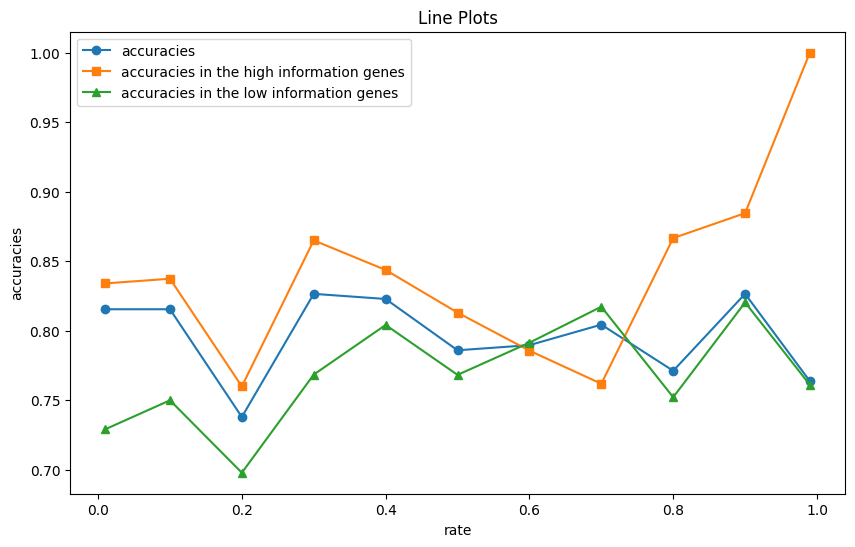

In [25]:
import matplotlib.pyplot as plt
df_sorted = df
# 设置画布
plt.figure(figsize=(10, 6))

# 画出每一列数据
plt.plot(df_sorted['rate'], df_sorted['accuracies in test dataset'], label='accuracies', marker='o')
plt.plot(df_sorted['rate'], df_sorted['accuracies in the high information genes'], label='accuracies in the high information genes', marker='s')
plt.plot(df_sorted['rate'], df_sorted['accuracies in the low information genes'], label='accuracies in the low information genes', marker='^')

# 设置图例
plt.legend()

# 设置x轴和y轴的标签
plt.xlabel('rate')
plt.ylabel('accuracies')

# 设置标题
plt.title('Line Plots')

# 显示图表
plt.show()
